# Introdução

Este notebook é uma continuação da EDA feita anteriormente. Aqui, iremos analisar possíveis modelos para o problema e avaliar sua precisão levando em conta a necessidade do problema.

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.metrics  import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.metrics import fbeta_score, plot_roc_curve, matthews_corrcoef, make_scorer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
sys.path.append("../scripts/")
from helper import *
from evaluate_model import *

In [69]:
path_raw_data = '../raw_data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
path_cleaned_data = '../data/Kaggle_Sirio_Libanes_ICU_Prediction_reduced.csv'

data = pd.read_excel(path_raw_data)
cleaned_data = pd.read_csv(path_cleaned_data)

pacient_id = ['PATIENT_VISIT_IDENTIFIER']
demographic_columns = ['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER']
preexisting_disease_columns = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER']
blood_results = ['ALBUMIN', 'BE_ARTERIAL', 'BE_VENOUS', 'BIC_ARTERIAL', 'BIC_VENOUS', 'BILLIRUBIN', 'BLAST', 'CALCIUM', 'CREATININ', 'FFA', 'GGT', 'GLUCOSE', 'HEMATOCRITE', 'HEMOGLOBIN', 'INR', 'LACTATE', 'LEUKOCYTES', 'LINFOCITOS', 'NEUTROPHILES', 'P02_ARTERIAL', 'P02_VENOUS', 'PC02_ARTERIAL', 'PC02_VENOUS', 'PCR', 'PH_ARTERIAL', 'PH_VENOUS', 'PLATELETS', 'POTASSIUM', 'SAT02_ARTERIAL', 'SAT02_VENOUS', 'SODIUM', 'TGO', 'TGP', 'TTPA', 'UREA', 'DIMER']
status_columns = ['WINDOW', 'ICU']

attributes_suffix = ['DIFF', 'DIFF_REL', 'MAX', 'MEAN', 'MEDIAN', 'MIN']
vital_signs = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC', 'HEART_RATE', 'OXYGEN_SATURATION', 'RESPIRATORY_RATE', 'TEMPERATURE']
vital_signs_columns = [f'{vs}_{attr}'for vs in vital_signs for attr in attributes_suffix]

In [70]:
cleaned_data[preexisting_disease_columns] = cleaned_data[preexisting_disease_columns].astype('bool')
cleaned_data[['AGE_ABOVE65', 'GENDER']] = cleaned_data[['AGE_ABOVE65', 'GENDER']].astype('bool')
cleaned_data['AGE_PERCENTIL'] = cleaned_data['AGE_PERCENTIL'].astype("category").cat.codes
cleaned_data['WINDOW'] = cleaned_data['WINDOW'].astype("category")#.cat.codes
cleaned_data['ICU'] = cleaned_data['ICU'].astype('bool')
cleaned_data.head()#describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,WINDOW,ICU
0,0,True,5,False,False,False,False,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,False
1,0,True,5,False,False,False,False,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,False
2,0,True,5,False,False,False,False,False,True,True,...,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,4-6,False
3,0,True,5,False,False,False,False,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,False
4,0,True,5,False,False,False,False,False,True,True,...,0.848485,0.925926,0.142857,-0.999067,-0.983994,-0.846633,-0.836145,-0.996762,ABOVE_12,True


# COVID-19 - Dados clínicos para avaliação de diagnóstico

O problema descrito pelos em [COVID-19 - Clinical Data to assess diagnosis](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

> <font size="5"><b>Context</b></font><br>
> COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources.
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.<br>
> <font size="5"><b>Call to action</b></font><br>
> There is urgency in obtaining accurate that to better predict and prepare healthcare systems and avoid collapse, defined by above capacity need of ICU beds (assuming human resources, PPE and professionals are available), using individual clinical data - in lieu of epidemiological and populational data.
> 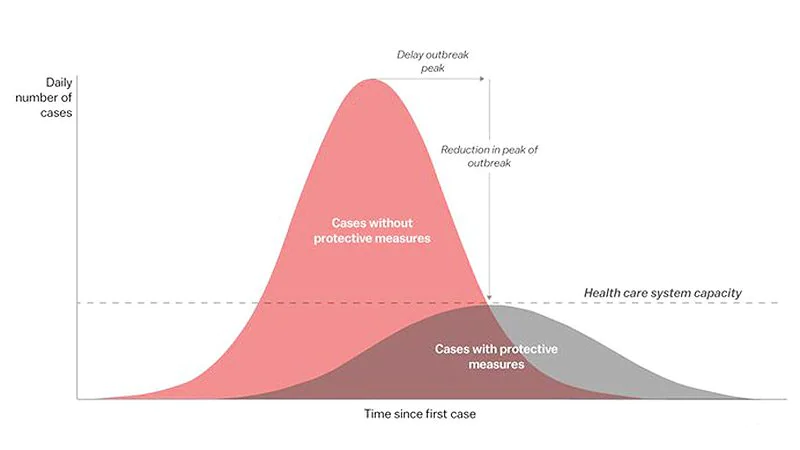<br>
> <font size="4"><b>Task 01</b></font><br>
Predict admission to the ICU of confirmed COVID-19 cases.
Based on the data available, is it feasible to predict which patients will need intensive care unit support?
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.<br>
> <font size="4"><b>Task 02</b></font><br>
Predict NOT admission to the ICU of confirmed COVID-19 cases.
Based on the subsample of widely available data, is it feasible to predict which patients will need intensive care unit support?
The aim is to provide local and temporary hospitals a good enough answer, so frontline physicians can safely discharge and remotely follow up with these patients.

><font size="5"><b>The Data</b></font><br>
><font size="4"><b>Label output</b></font><br>
ICU should be considered, as the first version of this dataset, the target variable.<br>
><font size="4"><b>Window Concept</b></font><br>
We were carefull to include real life cenarios of with window of events and available data.
Data was obtain and grouped<br>
>* patient
    - patient encounter
    - aggregated by windows in chronological order
| Window | Description |
|------|------|
| 0-2 | From 0 to 2 hours of the admission |
| 2-4 | From 2 to 4 hours of the admission |
| 4-6 | From 4 to 6 hours of the admission |
| 6-12 | From 6 to 12 hours of the admission |
| Above-12 | Above 12 hours from admission |

><b>Beware</b> NOT to use the data when the target variable is present, as it is unknown the order of the event (maybe the target event happened before the results were obtained). They were kept there so we can grow this dataset in other outcomes latter on.<br>
Examples:<br>
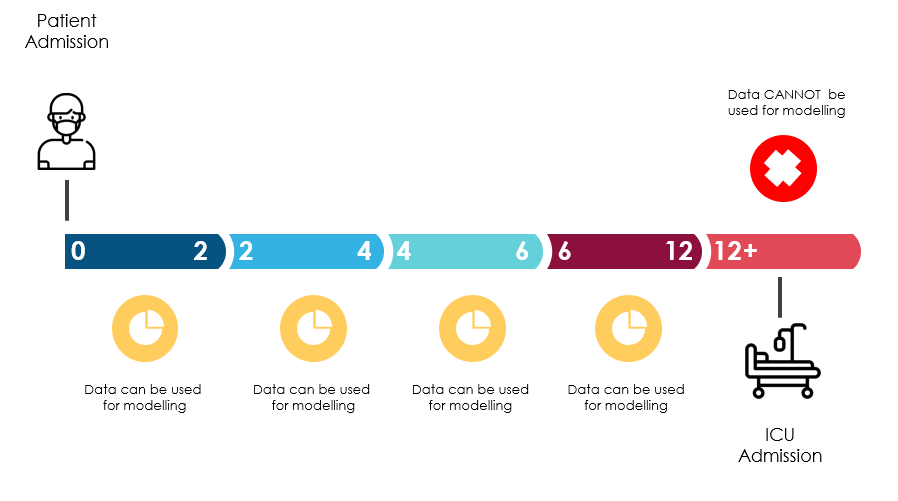<br>
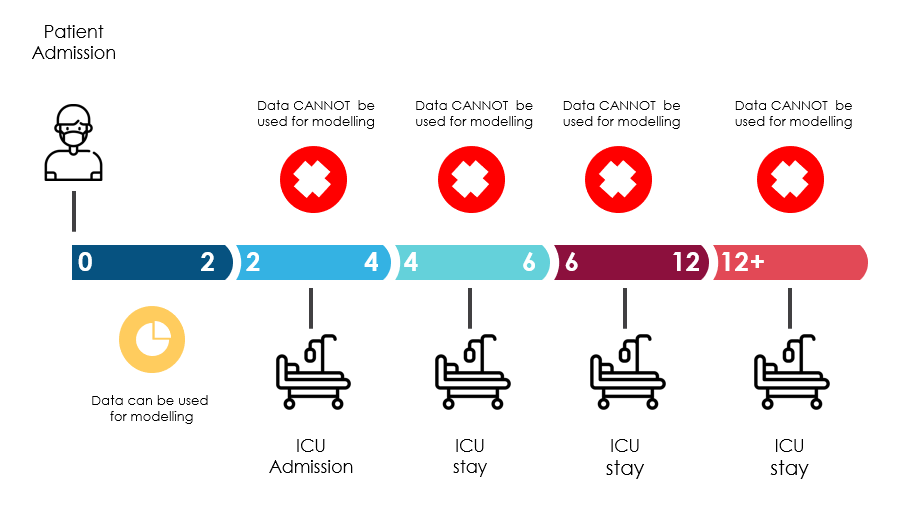<br>
><font size="4"><b>Tips & Tricks</b></font><br>
<font size="3"><b>Missing data</b></font><br>
Problem: One of the major challenges of working with health care data is that the sampling rate varies across different type of measurements. For instance, vital signs are sampled more frequently (usually hourly) than blood labs (usually daily).<br>
Tips & Tricks: It is reasonable to assume that a patient who does not have a measurement recorded in a time window is clinically stable, potentially presenting vital signs and blood labs similar to neighboring windows. Therefore, one may fill the missing values using the next or previous entry. Attention to multicollinearity and zero variance issues in this data when choosing your algorithm.<br>
<font size="3"><b>The earlier, the better!</b></font><br>
Problem: Early identification of those patients who will develop an adverse course of illness (and need intensive care) is a key for an appropriate treatment (saving lives) and to managing beds and resources.<br>
Tips & Tricks: Whereas a predictive model using all time windows will probably yield a greater accuracy, a nice model using *only the first (0-2)* is likely to be more clinically relevant. The creativity is very welcome though, please feel free with feature engineering and time windows. Attention to repeated measures on individuals once these values are (positively) correlated when playing around with data.

### Conclusão

Tão importante quanto prever se o paciente precisará de UTI, é garantir que o qual não precisa de UTI está correto. De fato, o impacto do falso negativo pode ser catastrófico, pois enviar alguem para casa que precisará de cuidados mais intensos pode ser crítico para a recuperação deste.

Focar em dados da primeira hora, quanto mais cedo for identificado que o paciente precisará de UTI, será melhor para alocar recursos ou mesmo monitorar este paciente com mais frequência

# Preparando os dados

## Preenchendo os dados

Como vimos anteriormente, nem todos os dados de sinais vitais e resultados de exame de sangue foram preenchidos. E como o Sírio-Libanês indica, esses resultados tem pouca variação, então podemos simplesmente preeencher os dados faltantes do paciente com os que estão preenchidos.

Como dito acima, "The earlier, the better!", portanto vamos focar apenas nos dados da primeira janela.

In [71]:
cleaned_data[['PATIENT_VISIT_IDENTIFIER'] + blood_results + ['WINDOW']].loc[cleaned_data['WINDOW'] == '0-2'].describe()

,PATIENT_VISIT_IDENTIFIER,ALBUMIN,BE_ARTERIAL,BE_VENOUS,BIC_ARTERIAL,BIC_VENOUS,BILLIRUBIN,BLAST,CALCIUM,CREATININ,...,PLATELETS,POTASSIUM,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER
count,385.000000,172.000000,172.0,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,...,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,192.000000,0.598378,-1.0,-0.969743,-0.324163,-0.339762,-0.945424,-0.998486,0.322081,-0.880815,...,-0.517481,-0.552110,0.929704,0.293641,-0.111517,-0.992598,-0.986338,-0.839337,-0.842225,-0.947486
std,111.284171,0.050078,0.0,0.079774,0.048259,0.105033,0.028824,0.019858,0.095041,0.156887,...,0.195637,0.199642,0.115853,0.347083,0.217534,0.024177,0.018309,0.041195,0.119613,0.166005
min,0.000000,0.210526,-1.0,-1.000000,-0.756098,-1.000000,-0.992674,-1.000000,-0.122449,-0.967445,...,-0.903872,-0.962963,-0.575758,-0.925926,-0.714286,-0.999627,-0.999619,-0.961853,-0.966265,-1.000000
25%,96.000000,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.962323,-1.000000,0.357143,-0.920736,...,-0.636849,-0.666667,0.939394,0.345679,-0.257143,-0.996827,-0.994379,-0.846633,-0.890361,-0.984003
50%,192.000000,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.000000,0.357143,-0.904459,...,-0.554072,-0.555556,0.939394,0.345679,-0.085714,-0.995428,-0.987805,-0.846633,-0.867470,-0.978029
75%,288.000000,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.000000,0.357143,-0.878273,...,-0.427904,-0.481481,0.939394,0.345679,0.038095,-0.995148,-0.986662,-0.846633,-0.816867,-0.958332
max,384.000000,0.684211,-1.0,-0.528796,-0.317073,-0.073171,-0.771847,-0.739568,0.693878,1.000000,...,0.228304,0.629630,0.939394,1.000000,1.000000,-0.693944,-0.794970,-0.640327,0.450602,1.000000


In [72]:
cleaned_data[['PATIENT_VISIT_IDENTIFIER'] + vital_signs_columns + ['WINDOW']].loc[cleaned_data['WINDOW'] == '0-2'].describe()

,PATIENT_VISIT_IDENTIFIER,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_MAX,...,RESPIRATORY_RATE_MAX,RESPIRATORY_RATE_MEAN,RESPIRATORY_RATE_MEDIAN,RESPIRATORY_RATE_MIN,TEMPERATURE_DIFF,TEMPERATURE_DIFF_REL,TEMPERATURE_MAX,TEMPERATURE_MEAN,TEMPERATURE_MEDIAN,TEMPERATURE_MIN
count,385.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,117.000000,117.000000,117.000000,117.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,192.000000,-0.979435,-0.982552,-0.343939,-0.065820,-0.064342,0.096847,-0.977430,-0.977368,-0.491813,...,-0.479409,-0.428178,-0.417919,-0.336386,-0.985558,-0.985453,-0.052507,0.156971,0.157201,0.474329
std,111.284171,0.065489,0.056424,0.192116,0.276801,0.281706,0.233779,0.072578,0.070531,0.232756,...,0.267766,0.292359,0.299286,0.308520,0.057801,0.059305,0.253460,0.318907,0.320900,0.202983
min,0.000000,-1.000000,-1.000000,-0.760684,-0.654321,-0.679012,-0.422680,-1.000000,-1.000000,-0.870270,...,-0.939394,-0.932203,-0.931034,-0.857143,-1.000000,-1.000000,-0.565217,-0.803571,-0.803571,-0.318681
25%,96.000000,-1.000000,-1.000000,-0.470085,-0.234568,-0.234568,-0.051546,-1.000000,-1.000000,-0.664865,...,-0.636364,-0.593220,-0.586207,-0.500000,-1.000000,-1.000000,-0.268116,-0.098214,-0.098214,0.318681
50%,192.000000,-1.000000,-1.000000,-0.350427,-0.061728,-0.061728,0.092784,-1.000000,-1.000000,-0.535135,...,-0.575758,-0.525424,-0.517241,-0.428571,-1.000000,-1.000000,-0.072464,0.107143,0.116071,0.450549
75%,288.000000,-1.000000,-1.000000,-0.247863,0.086420,0.086420,0.237113,-1.000000,-1.000000,-0.351351,...,-0.393939,-0.322034,-0.379310,-0.285714,-1.000000,-1.000000,0.101449,0.357143,0.357143,0.598901
max,384.000000,-0.565217,-0.574091,0.384615,1.000000,1.000000,1.000000,-0.546012,-0.610018,0.405405,...,0.636364,0.830508,0.862069,1.000000,-0.547619,-0.519055,0.623188,1.000000,1.000000,1.000000


Para ambos os grupos, nem todos os dados foram preenchidos para a primeira janela. Para os exames de sangue, que são medidos diariamente, temos 172 medidas em 385 pacientes, enquanto para sinais vitais, temos alguns resultados para 117.

Como afirmado em "Window concept", não podemos usar dados de quando o paciente foi internado na UTI. E como dito em "Tips & Tricks", é seguro assumir que os dados faltantes são provaveis de permanecerem os mesmos. Portanto, vamos seguir usando `ffill` e `bfill`. Por hora, vamos seguir com a estratégia mais simples.

In [73]:
def fill_data(df, columns_to_fill, groupby_columns = ['PATIENT_VISIT_IDENTIFIER', 'ICU']):
    df[columns_to_fill] = df.groupby(groupby_columns, as_index=False)[columns_to_fill].fillna(method='ffill').fillna(method='bfill')
    return df

simple_filled_data = fill_data(cleaned_data, blood_results)
simple_filled_data = fill_data(simple_filled_data, vital_signs_columns)

## Selecionando os dados

### Selecionando apenas a janela de 0-2 horas

Vamos criar uma colunas para marcar quais pacientes foram enviados a UTI com `HB_ICU`.

In [74]:
simple_filled_data['HB_ICU'] = 0

In [75]:
def select_window(rows, window):
    if(np.any(rows['ICU'])):
        rows.loc[lambda df: df['WINDOW'].isin(window), 'HB_ICU'] = 1
    return rows.loc[rows['WINDOW'].isin(window)]

data_window02 = simple_filled_data.groupby('PATIENT_VISIT_IDENTIFIER').apply(select_window, ['0-2']).reset_index(drop=True)

E como não podemos usar dados de quem já está na UTI, vamos excluir estas linhas.

In [76]:
data_window02 = data_window02[data_window02['ICU'] == 0]
data_window02#.reset_index()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,WINDOW,ICU,HB_ICU
0,0,True,5,False,False,False,False,False,True,True,...,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0-2,False,1
2,2,False,0,False,False,False,False,False,False,False,...,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,0-2,False,1
3,3,False,3,True,False,False,False,False,False,False,...,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0-2,False,0
4,4,False,0,False,False,False,False,False,False,False,...,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0-2,False,0
5,5,False,0,False,False,False,False,False,False,False,...,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,0-2,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,380,False,3,True,False,False,False,False,False,False,...,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,0-2,False,1
381,381,True,9,False,False,False,False,False,False,False,...,0.345679,-0.314286,-0.998507,-0.995808,-0.846633,-0.855422,-0.978029,0-2,False,0
382,382,False,4,False,False,False,False,False,False,False,...,0.345679,-0.085714,-0.995428,-0.986662,-0.846633,-0.787952,-0.964461,0-2,False,1
383,383,False,3,True,False,False,False,False,False,False,...,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.937349,-0.978029,0-2,False,0


## Colunas altamente correlacionadas

Já removemos anteriormente algumas colunas que não agregavam, como as colunas de `DIFF` dos exames de sangue e os valores repetidos. Agora, vamos observar as colunas que são correlacionados entre si para reduzir a dimensionalidade do problema e evitar o viés nos dados.

In [77]:
def list_high_correlate_columns(df, threashold = 0.9):
    cor_matrix = df.corr().abs()
    cor_list = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool)).stack().reset_index()
    cor_list.columns = ['level_0', 'level_1', 'correlation']
    return cor_list.loc[cor_list['correlation'] > threashold].reset_index(drop=True)

# hcc_simple_filled = list_high_correlate_columns(simple_filled_data)['level_1'].to_list()
hcc_window02 = list_high_correlate_columns(data_window02)['level_1'].to_list()
# print(hcc_simple_filled)
print(f'List of High correlated columns: {hcc_window02}')


List of High correlated columns: ['BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_MEAN', 'BLOODPRESSURE_SISTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_MIN', 'HEART_RATE_DIFF_REL', 'HEART_RATE_MEAN', 'HEART_RATE_MEDIAN', 'HEART_RATE_MIN', 'HEART_RATE_MEDIAN', 'HEART_RATE_MIN', 'HEART_RATE_MIN', 'OXYGEN_SATURATION_DIFF_REL', 'OXYGEN_SATURATION_MEAN', 'OXYGEN_SATURATION_MEDIAN', 'OXYGEN_SATURATION_MEDIAN', 'OXYGEN_SATURATION_MIN', 'OXYGEN_SATURATION_MIN', 'RESPIRATORY_RATE_DIFF_REL', 'RESPIRATORY_RATE_MEAN', 'RESPIRATORY_RATE_MEDIAN', 'RESPIRATORY_RATE_MEDIAN', 'RESPIRATORY_RATE_MIN', 'RESPIRATORY_RATE_MIN', 'TEMPERATURE_DIFF_REL', 'TEMPERATURE_MEAN', 'TEMPERATURE_MEDIAN', 'TEMPERATURE_MEDIAN', 'TEMPERATURE_MIN', 'TEMPERATURE_

# Comparação entre modelos

Temos em mãos um problema de classficaçãom, onde temos que definir se o paciente vai ou não precisar de UTI. Existem várias técnicas de aprendizado de máquina que podem ser aplicados para problemas de classificação. Abaixo vamos comparar a matriz de confusão de cada modelo com os parâmetros padrão do _sklearn_. Além da matriz de confusão, vamos usar a métrica de F-Score.

## Modelos para a janela de 0-2 horas

Como vamos utilizar a janela de 0-2, podemos remover as colunas `PATIENT_VISIT_IDENTIFIER`, `WINDOW` e `ICU`.

In [11]:
data_window02 = data_window02.drop(columns=['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU'])

In [12]:
x_columns = data_window02.columns[:-1]
x = data_window02[x_columns] # Entrada
y = data_window02['HB_ICU'] # saida

np.random.seed(73246)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

## Executando os Classificadores

In [13]:
names = ["Dummy", "K Neighbors", "Linear SVM", "RBF SVM", "Gaussian",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "GBC"]

classifiers = [
    DummyClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier()
]

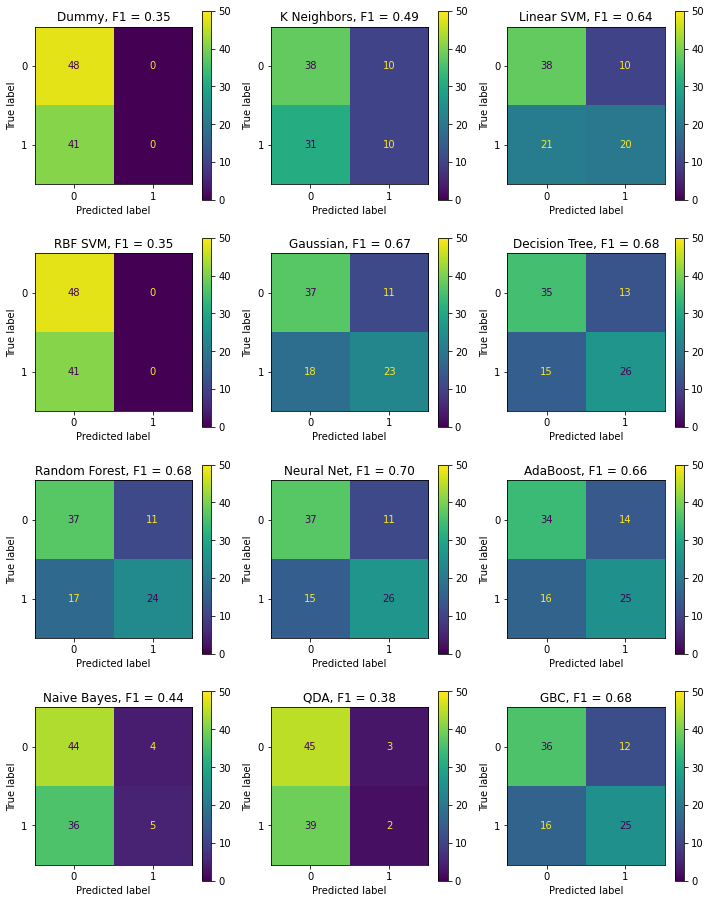

In [14]:
def plot_confusion_matrix_for_models(names, classifiers, nrows, ncols):
    np.random.seed(73246)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 16))
    axis = []
    for ax in axes:
        axis.extend(ax)
    axes_ind = 0
    trained_models = []
    for name, clf in zip(names, classifiers):
        clf.fit(x_train, y_train)
        trained_models.append(clf)
        disp = plot_confusion_matrix(clf, x_test, y_test, ax=axis[axes_ind])
        y_predict = clf.predict(x_test)
        auc_medio = fbeta_score(y_test, y_predict, average='macro', beta=1)
        axis[axes_ind].set_title(f'{name}, F1 = {auc_medio:.2f}')
        disp.im_.set_clim(0, 50)
        axes_ind += 1
    plt.show()
    for ax in axis[len(names):]:
        ax.set_visible(False)
        fig.delaxes(ax)
    return trained_models
_ = plot_confusion_matrix_for_models(names, classifiers, 4, 3)

_Random Forest_ e _Gradient Boost Classifier_ apresentaram bons resultados na matriz de confusão e bons valores com F-Score. Vamos executar o mesmo teste removendo as colunas correlacionadas

#### Removendo as colunas altamente correlacionadas.

In [15]:
data_window02_dropped = data_window02.drop(columns=hcc_window02)
data_window02_dropped

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,POTASSIUM,SAT02_ARTERIAL,SAT02_VENOUS,SODIUM,TGO,TGP,TTPA,UREA,DIMER,HB_ICU
0,True,5,False,False,False,False,False,True,True,False,...,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,1
2,False,0,False,False,False,False,False,False,False,False,...,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,1
3,False,3,True,False,False,False,False,False,False,False,...,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0
4,False,0,False,False,False,False,False,False,False,False,...,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0
5,False,0,False,False,False,False,False,False,False,False,...,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,False,3,True,False,False,False,False,False,False,False,...,-0.629630,0.939394,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,1
381,True,9,False,False,False,False,False,False,False,False,...,-0.518519,0.939394,0.345679,-0.314286,-0.998507,-0.995808,-0.846633,-0.855422,-0.978029,0
382,False,4,False,False,False,False,False,False,False,False,...,-0.407407,0.939394,0.345679,-0.085714,-0.995428,-0.986662,-0.846633,-0.787952,-0.964461,1
383,False,3,True,False,False,False,False,False,False,False,...,-0.555556,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.937349,-0.978029,0


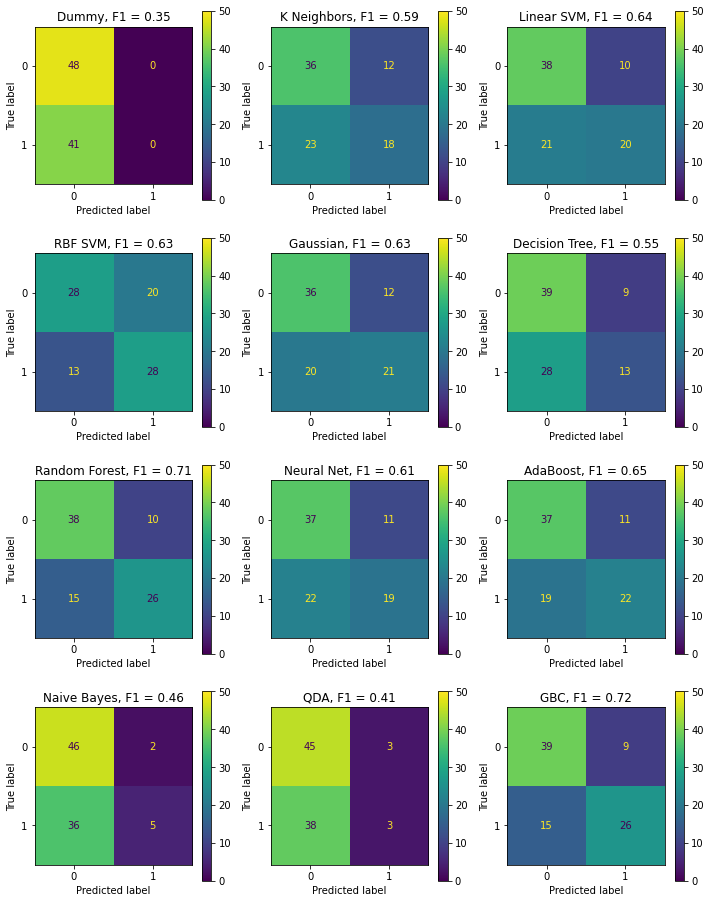

In [16]:
x_columns = data_window02_dropped.columns[:-1]
x = data_window02_dropped[x_columns] # Entrada
y = data_window02_dropped['HB_ICU'] # saida

np.random.seed(73246)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
models = plot_confusion_matrix_for_models(names, classifiers, 4, 3)

Vários classificadores tiveram métricas melhores após remover as colunas correlacionadas. E _Random Forest_ e _Gradient Boost Classifier_ continuam apresentando os melhores resultados. E como haviamos observado pela descrição do problema, é preciso observar os resultados de Falso Positivo.

## Gradient Boost Classifier

### Random Search

Como temos resultados promissores com _Gradient Boost Classifier_, vamos utilizar uma ferramenta do _sklearn_ que é _Random Search_.

Com esta técnica, definimos valores para os quais os hiper-parêmetros podem variar, e ao final da execução, temos o melhor modelo encontrado.

/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars


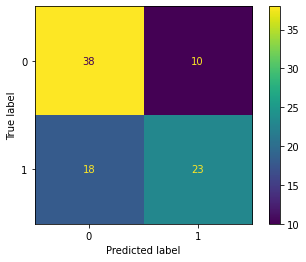

In [17]:
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

gbc_rscv_model = GradientBoostingClassifier()
gbc_rscv_parameters = {
    "learning_rate" : sp_randFloat(0.1, 2.0),
    "max_depth" : sp_randInt(1, 20),
    "max_features" : sp_randFloat(0.01, 1.0),
    "min_samples_leaf" : sp_randInt(1, 30),
    "min_samples_split" : sp_randInt(2, 30),
    "n_estimators" : sp_randInt(100, 400)
}
np.random.seed(73246)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
gbc_rscv = RandomizedSearchCV(gbc_rscv_model, param_distributions=gbc_rscv_parameters,
                              n_iter = 200, cv = cv, scoring=mcc_scorer, n_jobs=5,
                              return_train_score=True)
gbc_rscv.fit(x_train, y_train)

plot_confusion_matrix(gbc_rscv, x_test, y_test)

In [18]:
results = pd.DataFrame(gbc_rscv.cv_results_)
best_index = results.iloc[gbc_rscv.best_index_]
auc_medio = results.iloc[gbc_rscv.best_index_]['mean_test_score']
auc_medio_treino = results.iloc[gbc_rscv.best_index_]['mean_train_score']

auc_std = results.iloc[gbc_rscv.best_index_]['std_test_score']

print(f'MCC  {auc_medio} - {auc_medio_treino}')

AUC  0.49260356909238034 - 1.0


In [19]:
gbc_rscv.best_params_

{'learning_rate': 0.5302915711473221,
 'max_depth': 12,
 'max_features': 0.6049627608747574,
 'min_samples_leaf': 29,
 'min_samples_split': 2,
 'n_estimators': 361}

O _Random Search_ não obteve um bom resultado, dado que o modelo incial com parâmetros padrão do skelearn tem melhores resultados.

### GBC encontrado manualmente

Testando várias combinações de hiper-parâmetros, encontramos a seguinte solução. Esta é melhor que a solução padrão do _sklearn_.

F1: 0.6946050284477557
             precision    recall  f1-score  support
0                 0.72      0.75  0.734694       48
1             0.692308  0.658537  0.675000       41
accuracy                          0.707865       89
macro avg     0.706154  0.704268  0.704847       89
weighted avg  0.707243  0.707865  0.707194       89


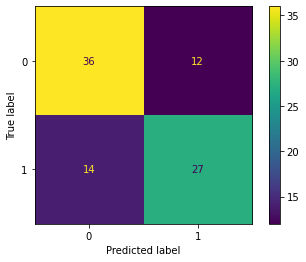

In [20]:
# Found manually
# clf = GradientBoostingClassifier(learning_rate=0.7, max_depth=12, max_features=0.3, min_samples_leaf=5, min_samples_split=6, n_estimators=260, subsample=1.0)
clf = GradientBoostingClassifier(learning_rate=0.5, max_depth=8, max_features=0.4, min_samples_leaf=3, min_samples_split=17, n_estimators=100, subsample=1.0)

model_manual = train_evaluate_classifier(clf, x, y, x_train, y_train, x_test, y_test)

## Random Forest

### Random Search

Similar ao que fizemos para o GBC, vamos utilizar o _Random Search_ para o modelo de _Random Forest_.

In [22]:
np.random.seed(73246)
rfc_rscv_model = RandomForestClassifier()
rfc_rscv_parameters = {
    "n_estimators" : sp_randInt(100, 400),
    "criterion" : ['gini', 'entropy'],
    "max_depth" : sp_randInt(1, 20),
    "min_samples_split" : sp_randInt(2, 30),
    "min_samples_leaf" : sp_randInt(1, 30),
    "max_features" : sp_randFloat(0.01, 1.0),
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
rfc_rscv = RandomizedSearchCV(rfc_rscv_model, param_distributions=rfc_rscv_parameters,
                              n_iter = 200, cv = cv, scoring=mcc_scorer, n_jobs=5,
                              return_train_score=True)
rfc_rscv.fit(x_train, y_train)

/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/mnt/c/Users/willianr/Documents/alura/COVID-19_clinical_data_assess_diagnosis/jupyter/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None),
                   estimator=RandomForestClassifier(), n_iter=200, n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfcb296c90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfc67da490>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfc67da610>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfc6357350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fcfcb2cff50>},
                   return_train_score=True,
                   scoring=make_scorer(matthews_corrcoef))

In [23]:
rfc_rscv.best_params_

{'criterion': 'entropy',
 'max_depth': 17,
 'max_features': 0.05448254926519657,
 'min_samples_leaf': 2,
 'min_samples_split': 18,
 'n_estimators': 217}

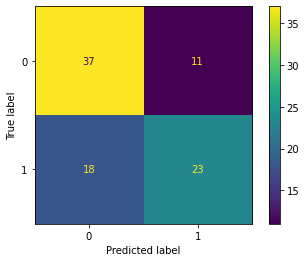

In [24]:
# train_evaluate_classifier(rfc_rscv, x, y, x_train, y_train, x_test, y_test, skip_fit = True)
plot_confusion_matrix(rfc_rscv, x_test, y_test)

Similar ao GBC, o _Random Search_ não obteve um bom resultado, dado que o modelo incial com parâmetros padrão do skelearn tem melhores resultados.

### Random Search anterior

Durante a execução deste projeto, um Random Search retornou um bom modelo. Porém, não havia configurado o _seed_ desta execução e não tenho como reproduzir as condições que criaram este modelo.

Lição aprendida: Salvar as condições que criaram o modelo, não apenas o modelo final.

F1: 0.704910776232045
             precision    recall  f1-score  support
0                 0.75    0.8125  0.780000       48
1             0.756757  0.682927  0.717949       41
accuracy                          0.752809       89
macro avg     0.753378  0.747713  0.748974       89
weighted avg  0.753113  0.752809  0.751415       89


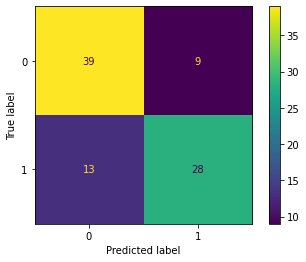

In [38]:
clf = RandomForestClassifier(criterion='gini', max_depth=6, max_features=0.30034845148359435, min_samples_leaf=6, min_samples_split=10, n_estimators=185)
rfc_rscv_best = train_evaluate_classifier(clf, x, y, x_train, y_train, x_test, y_test)

## Gradient Boost Classifier vs Random Forest

Vamos comparar os resultados entre os modelos encontrados.

In [106]:
def compare_table(df):
    dict_df = {}
    dict_df['Precision 0'] = df['precision'][0]
    dict_df['Precision 1'] = df['precision'][1]
    dict_df['Recall 0'] = df['recall'][0]
    dict_df['Recall 1'] = df['recall'][1]
    dict_df['F1-Score 0'] = df['f1-score'][0]
    dict_df['F1-Score 1'] = df['f1-score'][1]
    dict_df['Accuracy'] = df['f1-score']['accuracy']
    return dict_df

def format_classification_report(test, predict):
    df_cr = pd.DataFrame(classification_report(test, predict, output_dict=True)).T
    df_cr['precision']['accuracy'] = ''
    df_cr['recall']['accuracy'] = ''
    df_cr['support']['accuracy'] = df_cr['support']['macro avg']
    df_cr['support'] = df_cr['support'].astype('int32')
    return df_cr

rfc_model = models[6]
gbc_model = models[11]

y_predict_rfc = rfc_model.predict(x_test)
y_predict_gbc = gbc_model.predict(x_test)
y_predict_rscv_best = rfc_rscv_best.predict(x_test)
y_predict_model_manual = model_manual.predict(x_test)

df_rfc = format_classification_report(y_test, y_predict_rfc)
df_gbc = format_classification_report(y_test, y_predict_gbc)
df_rscv_best = format_classification_report(y_test, y_predict_rscv_best)
df_model_manual = format_classification_report(y_test, y_predict_model_manual)

In [107]:
df_models = [df_rfc, df_gbc, df_model_manual, df_rscv_best]

dict_models = []
for m in df_models:
    dict_models.append(compare_table(m))
df_models_comparison = pd.DataFrame(dict_models)
df_models_comparison.index = ['Random Forest Classifier', 'Gradient Boost Classifier', 'Gradient Boost Classifier - Manual', 'Random Forest Classifier - Best']
df_models_comparison

,Precision 0,Precision 1,Recall 0,Recall 1,F1-Score 0,F1-Score 1,Accuracy
Random Forest Classifier,0.716981,0.722222,0.791667,0.634146,0.752475,0.675325,0.719101
Gradient Boost Classifier,0.722222,0.742857,0.812500,0.634146,0.764706,0.684211,0.730337
Gradient Boost Classifier - Manual,0.720000,0.692308,0.750000,0.658537,0.734694,0.675000,0.707865
Random Forest Classifier - Best,0.750000,0.756757,0.812500,0.682927,0.780000,0.717949,0.752809


Dentre os 4 modelos, o melhor foi o _Random Forest Classifier_ encontrado com random search perdido :D.

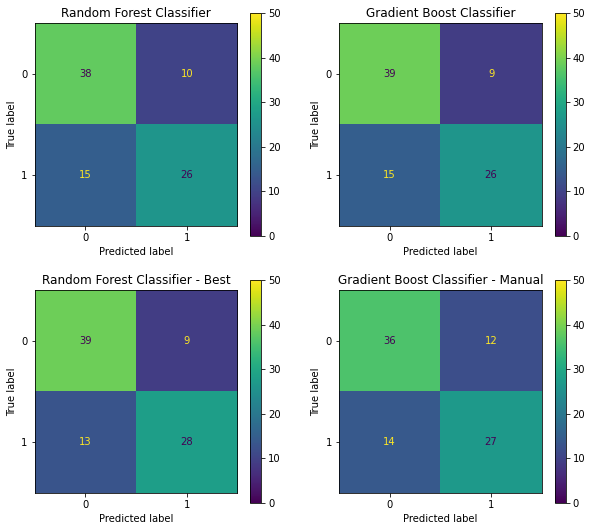

In [36]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))

disp = plot_confusion_matrix(rfc_model, x_test, y_test, ax=ax11)
disp.im_.set_clim(0, 50)
ax11.set_title('Random Forest Classifier')

disp = plot_confusion_matrix(gbc_model, x_test, y_test, ax=ax12)
disp.im_.set_clim(0, 50)
ax12.set_title('Gradient Boost Classifier')

disp = plot_confusion_matrix(rfc_rscv_best, x_test, y_test, ax=ax21)
disp.im_.set_clim(0, 50)
ax21.set_title('Random Forest Classifier - Best')

disp = plot_confusion_matrix(model_manual, x_test, y_test, ax=ax22)
disp.im_.set_clim(0, 50)
ax22.set_title('Gradient Boost Classifier - Manual')
plt.show()

E acima, temos recaptulando, as matrizes de confusão dos modelos.

### Overfit

Vamos verificar se o modelo está com overfit sobre os dados de treino.

In [ ]:
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
def roda_modelo_cv(modelo, dados, n_splits, n_repeat):
    np.random.seed(73246)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeat)
    resultados = cross_validate(modelo, x, y, cv=cv, scoring=mcc_scorer, return_train_score=True, n_jobs=6)

    test_score_mean = np.mean(resultados['test_score'])
    test_score_std = np.std(resultados['test_score'])
    
    train_score_mean = np.mean(resultados['train_score'])
    train_score_std = np.std(resultados['train_score'])

    print(f'Test: {test_score_mean}')
    print(f'Test STD: {test_score_std}')
    print(f'Test Intervalo: {test_score_mean + 2*test_score_std} - {test_score_mean - 2*test_score_std}')
    print(f'Train: {train_score_mean}')
    print(f'Train STD: {train_score_std}')
    print(f'Train Intervalo: {train_score_mean + 2*train_score_std} - {train_score_mean - 2*train_score_std}')
    return resultados

In [49]:
print('Gradient Boost Classifier - Manual')
_ = roda_modelo_cv(model_manual, x, 5, 10)
print()
print('Random Forest Classifier - Best')
_ = roda_modelo_cv(rfc_rscv_best, x, 5, 10)

Gradient Boost Classifier - Manual
Test: 0.4376541189286886
Test STD: 0.083737058581404
Test Intervalo: 0.6051282360914966 - 0.27018000176588064
Train: 1.0
Train STD: 0.0
Train Intervalo: 1.0 - 1.0

Random Forest Classifier - Best
Test: 0.44989589767900773
Test STD: 0.08119831895797651
Test Intervalo: 0.6122925355949608 - 0.2874992597630547
Train: 0.8119698039980829
Train STD: 0.024742613704108612
Train Intervalo: 0.8614550314063002 - 0.7624845765898657


E nosso melhor modelo encontrado não está com overfit!

# Conclusão

Frente a tarefa proposta de prever quais pacientes precisarão de UTI e quais não precisarão. Temos um modelo rasoavelmente robusto. Porém dada a segunda tarefa, de prever quais pacientes não precisarão de UTI. Enviar errôniamente um paciente para casa pode ser um erro crítico que será decisivo na evolução da recuperação do paciente.

Como forma de previnir e de trablhos futuros, utilizar mais janelas de tempo pode ser uma excelente adição na previsibilidade.

Este projeto faz parte do bootcamp da Alura de Data Science. Como parte do aprendizado, temos o melhor modelo encontrado e não é possível reproduzir as condições que geraram ele. Ficando como aprendizado a garantir a reproducibilidade dos resultados.